# Dphi Data Sprint 88 - Abalone Age Prediction
## Predict the age of abalone from physical measurements.

## Methodology:
1. Visualize the data and perform exploratory analysis based on univariate and multivariate analysis
2. Target is integral, so results will be rounded before submission
3. Data scales are different, so will be normalized before running the models
4. We will use cross validation to decide on the best model to be used
5. We will use Grid Search CV to narrow down the best hyperparameters for different dataset splits
6. Next we will manually finetune the best model hyperparameters for the best dataset split
7. Finally we will make predictions and submit the results

## Import the libraries

In [65]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from tqdm import tqdm
import time

## Define the filepaths

In [2]:
train_path = '/home/sandeep/Development/Datasets/Nature/abalone_age/train_dataset.csv'
test_path = '/home/sandeep/Development/Datasets/Nature/abalone_age/test_dataset.csv'

## Read the datasets

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
display(train_df.head(1))
display(test_df.head(1))

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M,rings
0,124,97,41,243.8,77.5,50.1,77.0,0,0,1,14


,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I,sex_M
0,111,87,29,139.5,52.4,31.5,48.0,0,1,0


## Visualize the target: looks normal

<AxesSubplot:ylabel='Frequency'>

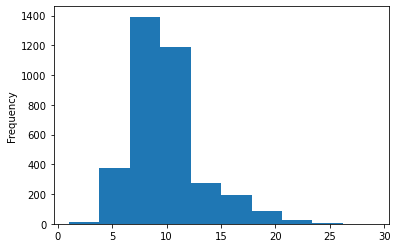

In [6]:
train_df.rings.plot(kind='hist')

### Target feature looks normal

## Univariate analysis

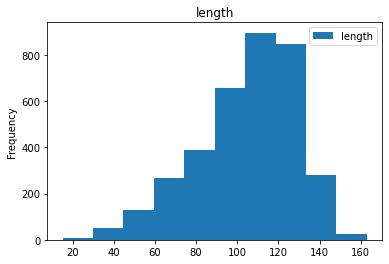

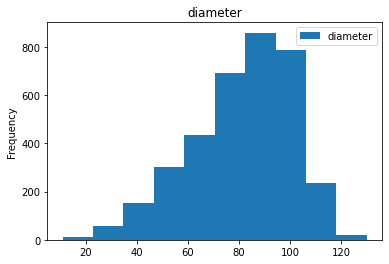

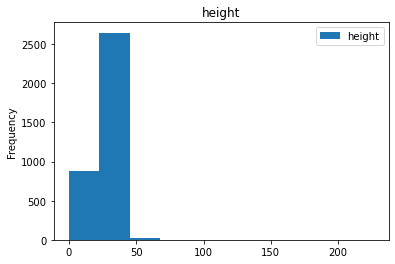

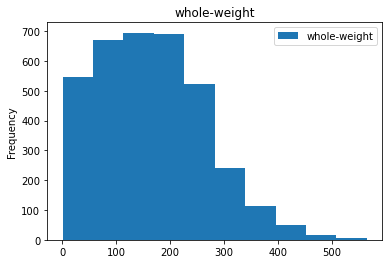

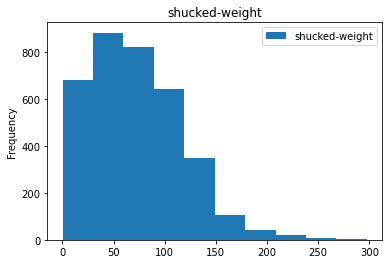

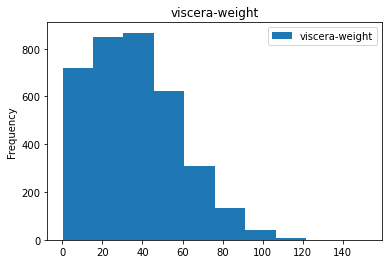

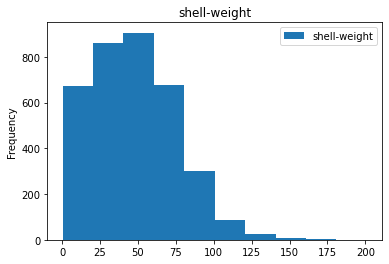

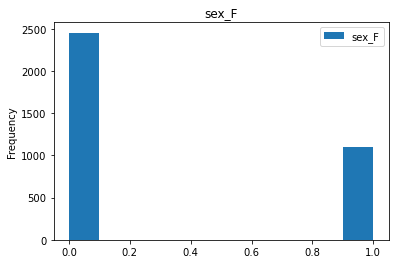

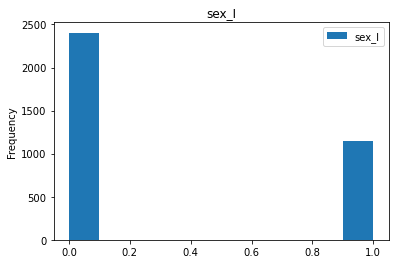

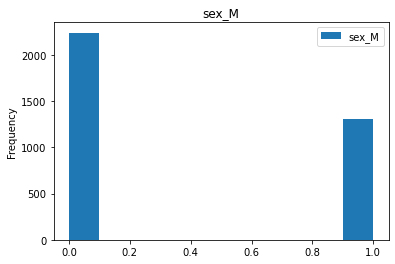

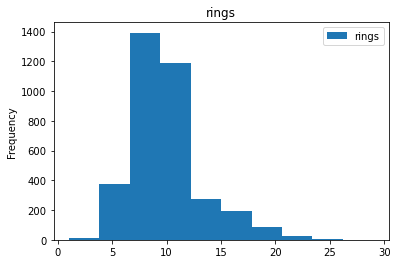

In [20]:
for i in train_df.columns:
    train_df[i].plot(kind='hist', title=i)
    plt.legend()
    plt.show()

### Other than height feature, all others look normal. For height feature, givan more data, we can think of log normalization

## Check the 'sex' features, they may have redundancy

In [13]:
train_df.iloc[:,-4:-1].sum().sum(), len(train_df)

(3550, 3550)

### The sum of the three 'sex' features is equal to length of the dataset. One of these features is redundant, and can be dropped. The two remaining features will be sufficient to explain the third.

## Bivariate analysis

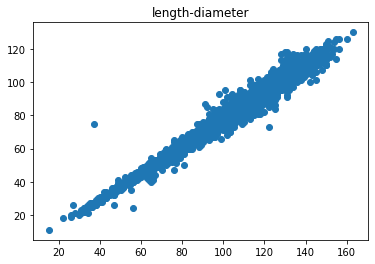

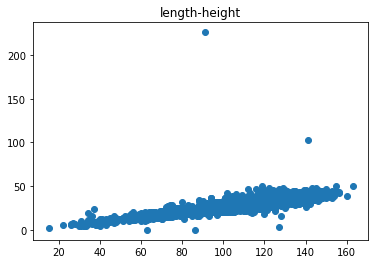

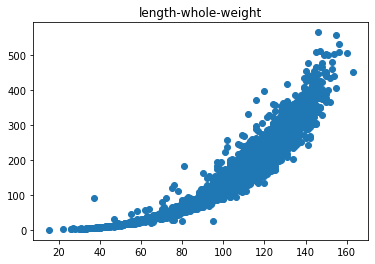

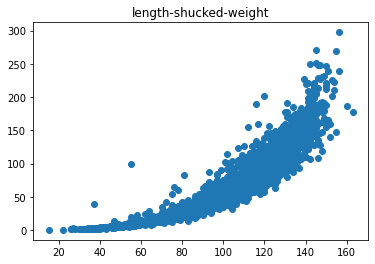

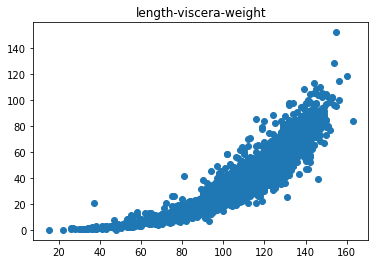

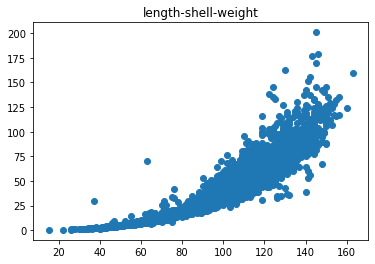

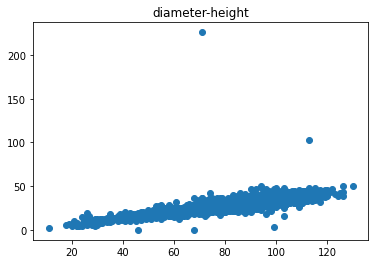

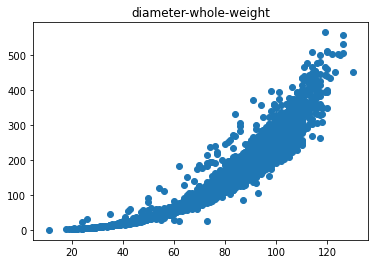

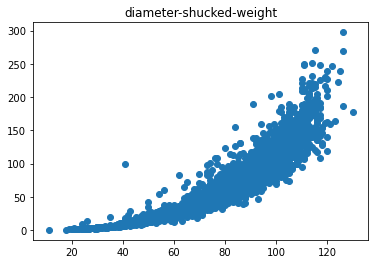

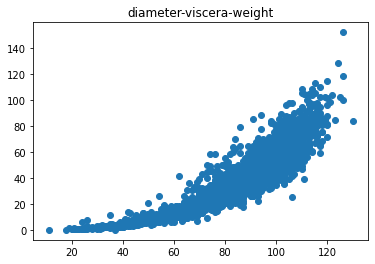

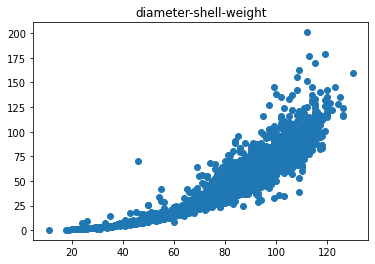

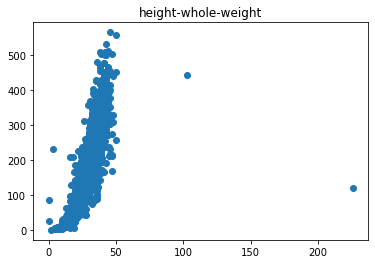

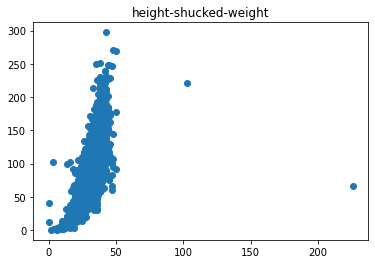

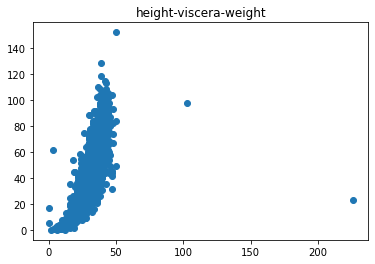

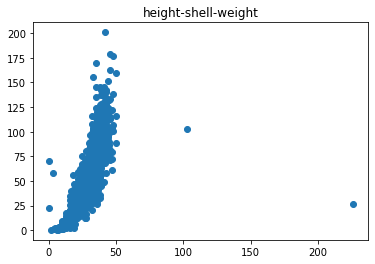

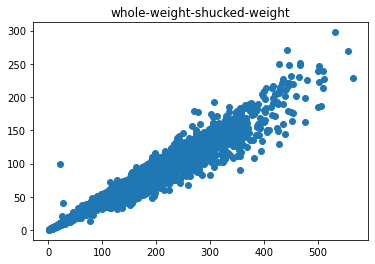

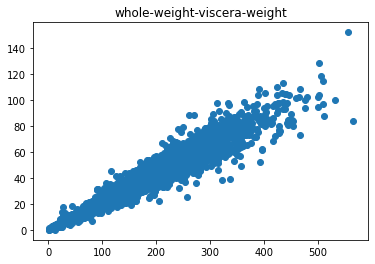

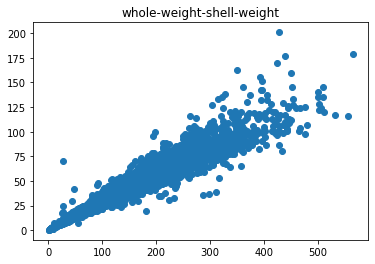

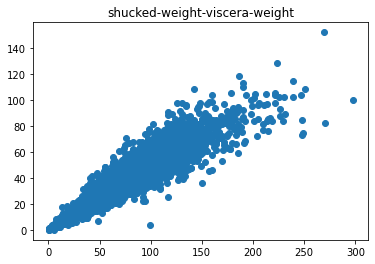

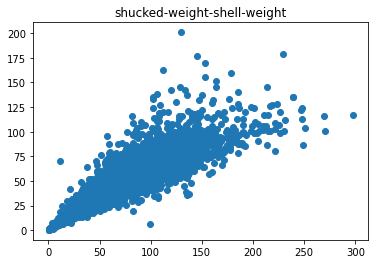

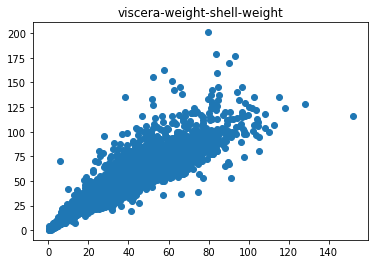

In [37]:
cols = list(train_df.iloc[:,:7].columns)
for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        plt.scatter(train_df[cols[i]], train_df[cols[j]])
        plt.title(cols[i]+'-'+cols[j])
        plt.show()

### Most of the parameters have linear relationships, except for weight. Because of weight, linear algorithms might perform poorly and tree algorithms or deep learning will perform better

### Still, the data is very clean, and can be straightaway used for modeling

## Feature Engineering, Feature Selection

## Separate the dependent and independent features

In [38]:
train_X = train_df.iloc[:,:-1].copy()
train_y = train_df.iloc[:,-1].copy()
final_X = test_df.copy()

## We had established that one of the sex columns was redundant, can be dropped

In [39]:
train_X.drop('sex_M', axis=1, inplace=True)
final_X.drop('sex_M', axis=1, inplace=True)

In [40]:
train_X.head(1)

,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,sex_F,sex_I
0,124,97,41,243.8,77.5,50.1,77.0,0,0


## The data has varying scales, so let's standardize the datasets

In [41]:
scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_X)
final_X_scaled = scaler.transform(final_X)

## Now we will define a list of models with their default parameters

In [61]:
models = {
'LIN': LinearRegression(),
'RID': Ridge(),
'LAS': Lasso(),
'RFR': RandomForestRegressor(),
'ADA': AdaBoostRegressor(),
'DCT': DecisionTreeRegressor(),
'XGB': XGBRegressor()
}

## Conduct cross validation to identify the best model to further explore

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train_X_scaled, train_y, test_size=0.25, random_state=42)
for name, model in models.items():
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    print(f"{name}: {-1*(cv_results.mean()):.1f}   {cv_results.std():.1f}")

LIN: 5.3   0.4
RID: 5.3   0.5
LAS: 10.9   1.2
RFR: 5.0   0.7
ADA: 7.6   0.6
DCT: 9.5   1.0
XGB: 5.5   0.9


# Decision: Model to be finetuned is Random Forest

## Declare the hyper parameters to iterate upon

In [63]:
params = { 'max_depth': [7, 8, 9, 10, 11, 12], 'max_features': [0.4, 0.5, 0.6, 0.7, 0.8], 
        'n_estimators' : [100, 150, 200]}

## Perform Grid Search operation to narrow down the parameters

In [84]:
t1=dt.datetime.now()
for i in tqdm([0.3, 0.25, 0.2, 0.15], colour='green'):
    X_train, X_test, y_train, y_test = train_test_split(train_X_scaled, train_y, test_size=i, random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = GridSearchCV(RandomForestRegressor(), param_grid=params, scoring='neg_mean_squared_error', 
                                cv=kfold, verbose=1).fit(X_train, y_train).best_estimator_
    print(f'\nThe best parameters for split {i} are: {model.get_params()}')
    preds = model.predict(X_test)
    ms = mse(y_test, np.round(preds).astype('int'))
    print(f'\nBest MSE for split {i} is: {ms}')
t2=dt.datetime.now()
print('\nTotal time taken: {t2-t1}')

  0%|                                                                                                                           | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 90 candidates, totalling 450 fits


 25%|████████████████████████████▌                                                                                     | 1/4 [10:02<30:06, 602.01s/it]


The best parameters for split 0.3 are: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 8, 'max_features': 0.7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Best MSE for split 0.3 is: 4.264788732394366
Fitting 5 folds for each of 90 candidates, totalling 450 fits


 50%|█████████████████████████████████████████████████████████                                                         | 2/4 [20:55<21:04, 632.08s/it]


The best parameters for split 0.25 are: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': 0.7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Best MSE for split 0.25 is: 4.024774774774775
Fitting 5 folds for each of 90 candidates, totalling 450 fits


 75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 3/4 [32:38<11:04, 664.68s/it]


The best parameters for split 0.2 are: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 0.5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Best MSE for split 0.2 is: 4.06056338028169
Fitting 5 folds for each of 90 candidates, totalling 450 fits


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [44:19<00:00, 664.89s/it]


The best parameters for split 0.15 are: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': 0.5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Best MSE for split 0.15 is: 4.3320825515947465

Total time taken: {t2-t1}


# Decision: Dataset split to be used is 0.25

In [85]:
X_train, X_test, y_train, y_test = train_test_split(train_X_scaled, train_y, test_size=0.25, random_state=42)

## Now we manually finetune the model for best score, starting with the above gridsearch result parameters as baseline

### Best params found for split 0.25: 'max_depth': 9, 'max_features': 0.7, 'n_estimators': 200

In [127]:
model_rfr = RandomForestRegressor(
    n_estimators=70,
    max_depth=9,
    max_features=0.7,
    random_state=1
)
model_rfr.fit(X_train, y_train)
preds = model_rfr.predict(X_test)
print(mse(y_test, np.round(preds).astype('int')))

3.9414414414414414


In [128]:
preds = model_rfr.predict(final_X_scaled)
preds = pd.DataFrame(np.round(preds).astype('int'), columns=['rings'])
preds.to_csv('/home/sandeep/Development/Datasets/Nature/abalone_age/submissions/submission.csv', index=False)

### Further access to more training and testing data can help us generalize the model further. For now, we can use the above frozen model for predictions.

# This is the end of the exercise